# Descarta de datos
Actualmente se estan descargando los datos del satelite **Sentinel-2**

Faltantes en el codigo:
- Descargar 2 imagenes, la imagen completa satlital correspondiendte a la zona de interés, quiero una imagen ligeramente más grande que el área de interes. 
- Hacer el filtro de nubosidad solo para el área de interés 

**ESTABLECIMIENTO DE FECHAS DE INTERES**

In [1]:
from datetime import datetime

# Create a specific date and time
start_date = datetime(year=2024, month=10, day=1)  # Year, Month, Day, con un digito las que son de 1

# end date
end_date = datetime(year=2025, month=1, day=8)

**IMPORTACION DE LIBRERIAS**

In [2]:
import os
import ee 
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import geemap
import pandas as pd

In [3]:
# Extración de fechas
start_year = start_date.year
start_month = start_date.month
start_day = start_date.day

end_year = end_date.year
end_month = end_date.month
end_day = end_date.day

## Autentificación para GCP 

In [4]:
# 1) Obtención de la dirección de trabajo 
direction = os.getcwd()

# Remove the last part of the path
direction = os.path.dirname(direction)

# Dirección de la llave 
service_account= direction + '/conf/local/gcp-for-data-science-397913-4fd843feede1.json'

# Autentificación 
credentials = ee.ServiceAccountCredentials(email=None,key_file=service_account)
ee.Initialize(credentials)

## 1) Importación del área de interés 
**NOTA:** Se obtiene el área de interés por medio de un archivo tipo Geojson, kml o shape. Para este ejemplo se utilizará un KML. 

### 1.1) Carga y visualización con geopandas

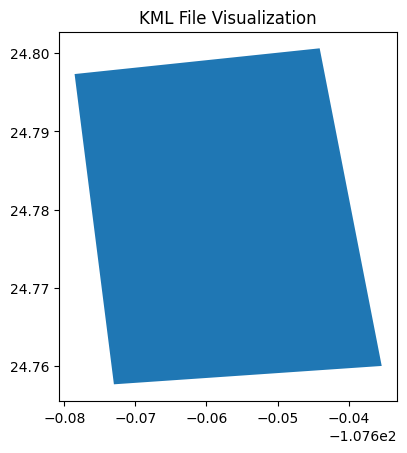

In [5]:
# Direction of the KML 
kml_file = direction + "/data/01_raw/Agricultura.kml"

# Nombre del archivo GeoJson a exportar 
geojson_file = direction + "/data/01_raw/Agricultura.geojson"

# 1) Lectura del kml 
gdf = gpd.read_file(filename=kml_file, driver="KML")

# 2) Exportación del kml a un Geo JSON 
gdf.to_file(filename=geojson_file, driver="GeoJSON")

# Plot using Geopandas
gdf.plot()

# Customize the plot
plt.title("KML File Visualization")
plt.show()

## 2) Descarga de imagenes satelitales
En esta sección se abordarán los siguientes procesos 

- **[Creación de un geometria para Earth Engine](https://developers.google.com/earth-engine/apidocs/ee-geometry)**: La geometria de earth engine se puede crear a partir de un GeoJSON, esto serivara para hacer el corte en las imagenes satelitales de interés
  
- Descarga de datos satelitales para esa área junto con un filtro al área de intrés, fechas y nubosidad 

### 2.1) Creación de una geometría de earth engine 
Para la creación de una geometría lo más indicado es convertir el KML en un archivo GeoJSON y este leerlo directamtne como geometría 

In [6]:
import json
# Step 1: Load the GeoJSON file

with open(geojson_file, "r") as f:
    geojson_data = json.load(f)

geojson_data["features"][0]["geometry"] # IMPORTANTE: Vease como contiene una tercera coordenada que es la altura (los valores de 0) , se deben de retirar 

{'type': 'Polygon',
 'coordinates': [[[-107.6730266244965, 24.75766085153008, 0.0],
   [-107.6353327971003, 24.76000824378666, 0.0],
   [-107.6440665193485, 24.80059938041618, 0.0],
   [-107.6785631858739, 24.79730942750482, 0.0],
   [-107.6730266244965, 24.75766085153008, 0.0]]]}

**Eliminación de la coordinada de elevación**

In [7]:
# Step 2: Function to remove the third dimension
def remove_third_dimension(geometry):
    """Removes the third dimension (z-values) from GeoJSON coordinates."""
    if geometry["type"] == "Polygon":
        geometry["coordinates"] = [
            [[coord[0], coord[1]] for coord in ring] for ring in geometry["coordinates"]
        ]
    elif geometry["type"] == "MultiPolygon":
        geometry["coordinates"] = [
            [[[coord[0], coord[1]] for coord in ring] for ring in polygon]
            for polygon in geometry["coordinates"]
        ]
    elif geometry["type"] == "LineString":
        geometry["coordinates"] = [[coord[0], coord[1]] for coord in geometry["coordinates"]]
    elif geometry["type"] == "Point":
        geometry["coordinates"] = geometry["coordinates"][:2]
    return geometry

# Step 3: Clean the geometry, ejecucón de la funcion 
cleaned_geometry = remove_third_dimension(geojson_data["features"][0]["geometry"])
cleaned_geometry # Vease ocmo aqui ya estan retirados la tercera dimensión de la altura 

{'type': 'Polygon',
 'coordinates': [[[-107.6730266244965, 24.75766085153008],
   [-107.6353327971003, 24.76000824378666],
   [-107.6440665193485, 24.80059938041618],
   [-107.6785631858739, 24.79730942750482],
   [-107.6730266244965, 24.75766085153008]]]}

**Convertir en geometría de Earth Engine**

In [8]:
# Step 4: Convert to Earth Engine Geometry
area_interest = ee.Geometry(cleaned_geometry)
type(area_interest)

ee.geometry.Geometry

### 2.2) Creación de un mapa base e integración de área de interés

**AÑADIMOS LA GEOMETRIA AL MAPA**

In [9]:
# 1) Creación del mapa base 
Map  = geemap.Map()

# Anadimos un base map distinto 
Map.add_basemap(basemap="Esri.WorldImagery")  # Imagene satelital de ESRI 

# 2) Add the geometry to the map
Map.addLayer(area_interest, {"color": "red"}, "Cleaned Geometry")

# Center the map on the geometry
Map.centerObject(area_interest, 11)

### 2.3) Descarga de imagenes satelitales

**IMPORTANTE:** Se hará la descarga de las imagenes en los años que se eligieron al inicio 

In [10]:
# Definición del diccionario de imágenes
image_dic = {}  # Lista vacía

# 1) Importación del image collection de Copernicus
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR")
            
# 2) Filtro por área de interés
sentinel2 = sentinel2.filterBounds(geometry=area_interest)

# 3) Filtro por fechas de interés
sentinel2 = sentinel2.filterDate(start=f"{start_year}-{start_month}-{start_day}",
                                 end=f"{end_year}-{end_month}-{end_day}")  # año, mes y día

# 4) Filtro por titulo, IMPORATNTE: de lo contrario apareceran 2 titulos de la misma imagen 
sentinel2 = sentinel2.filter(ee.Filter.eq('MGRS_TILE', '12RZN'))

# 5) Filtro por nubosidad
sentinel2 = sentinel2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # nubosidad menor al 20%
# NOTE: This is still a image collection object

# 6) Seleccion Bandas necesarias
sentinel2 = sentinel2.select(['B2', 'B3', 'B4', 'B8', 'B11'])

  # Bandas seleccionadas:
    # - B2: Banda azul, central Wavelength = 490nm
    # - B3: Banda verde, central Wavelength = 560nm
    # - B4: Banda roja, central Wavelength = 665nm
    # - B8: Banda Near Infrared, central Wavelength = 842nm
    # - B11: Banda (SWIR 1), central Wavelength = 1610nm

type(sentinel2) # Esto es una image collection

ee.imagecollection.ImageCollection

In [11]:
# Get the list of image IDs from the filtered ImageCollection
image_ids = sentinel2.aggregate_array('system:index').getInfo()
image_ids

['20241004T174109_20241004T175248_T12RZN',
 '20241014T174209_20241014T174540_T12RZN',
 '20241019T174341_20241019T174809_T12RZN',
 '20241024T174319_20241024T175436_T12RZN',
 '20241029T174441_20241029T175146_T12RZN',
 '20241103T174419_20241103T175519_T12RZN',
 '20241108T174541_20241108T175436_T12RZN',
 '20241113T174509_20241113T175617_T12RZN',
 '20241118T174631_20241118T175637_T12RZN',
 '20241123T174559_20241123T175306_T12RZN',
 '20241128T174701_20241128T174941_T12RZN',
 '20241203T174629_20241203T174733_T12RZN',
 '20241218T174741_20241218T175528_T12RZN',
 '20241223T174649_20241223T174803_T12RZN',
 '20241228T174741_20241228T175120_T12RZN',
 '20250102T174639_20250102T175210_T12RZN']

In [12]:
# Get IDs and dates
image_list = sentinel2.toList(sentinel2.size()) # Esto genera una ee list que contiene todo el listado de imagenes con sus metadados

# Lista donde se almacenara el ID de las imagenes y su fecha
ids_and_dates = []

for i in range(image_list.size().getInfo()): # Esto va iterar sobre la lista de de earth engine
    # Aqui  se esta obteniedo cada imagen de la lista
    image = ee.Image(image_list.get(i))

    # Se topa el ID de la imagen
    image_id = image.get('system:index').getInfo()

    # Se toma la fecha de imagen
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

    # Se integra los resultados a la lista
    ids_and_dates.append({'ID': image_id, 'Date': date})

# Convertirlo a un pandas DF 
ids_and_dates = pd.DataFrame(data=ids_and_dates)
ids_and_dates.head(n=5) # Visualizacion 
# IMPORTQNTE: Vease que cada fecha tiene 2 imagenes, las inspecciones y son básicamente las mismas

,ID,Date
0,20241004T174109_20241004T175248_T12RZN,2024-10-04
1,20241014T174209_20241014T174540_T12RZN,2024-10-14
2,20241019T174341_20241019T174809_T12RZN,2024-10-19
3,20241024T174319_20241024T175436_T12RZN,2024-10-24
4,20241029T174441_20241029T175146_T12RZN,2024-10-29


In [23]:
# 1) Tranformar la columna Date a tipo date 
ids_and_dates['Date'] = pd.to_datetime(arg=ids_and_dates['Date'])

# 2) Obtención de los datos de interes
ids_and_dates["Year"] = ids_and_dates["Date"].dt.year
ids_and_dates["Month"] = ids_and_dates["Date"].dt.month
ids_and_dates["Week"] = ids_and_dates["Date"].dt.isocalendar().week
ids_and_dates["Day_of_the_week"] = ids_and_dates["Date"].dt.dayofweek

# 3) Generating and alternative ID
ids_and_dates["ID_Code"] =  (
                            ids_and_dates["Year"].astype(str) +
                            ids_and_dates ["Month"].astype(str) +
                            ids_and_dates["Week"].astype(str)
                             )

print("Cantidad de imagenes:", len(ids_and_dates))
ids_and_dates # Si existen semanas con más de 1 imagen por semana, por lo que nos quedaremos solo con 1 imagen por semana

Cantidad de imagenes: 16


,ID,Date,Year,Month,Week,Day_of_the_week,ID_Code
0,20241004T174109_20241004T175248_T12RZN,2024-10-04,2024,10,40,4,20241040
1,20241014T174209_20241014T174540_T12RZN,2024-10-14,2024,10,42,0,20241042
2,20241019T174341_20241019T174809_T12RZN,2024-10-19,2024,10,42,5,20241042
3,20241024T174319_20241024T175436_T12RZN,2024-10-24,2024,10,43,3,20241043
4,20241029T174441_20241029T175146_T12RZN,2024-10-29,2024,10,44,1,20241044
5,20241103T174419_20241103T175519_T12RZN,2024-11-03,2024,11,44,6,20241144
6,20241108T174541_20241108T175436_T12RZN,2024-11-08,2024,11,45,4,20241145
7,20241113T174509_20241113T175617_T12RZN,2024-11-13,2024,11,46,2,20241146
8,20241118T174631_20241118T175637_T12RZN,2024-11-18,2024,11,47,0,20241147
9,20241123T174559_20241123T175306_T12RZN,2024-11-23,2024,11,47,5,20241147


**Selección de imagenes por semana**

In [25]:
# Group by Year, Month, Week and find the index of the minimum "Day_of_the_week"
idx = ids_and_dates.groupby(["Year", "Month", "Week"])["Day_of_the_week"].idxmin()
idx

Year  Month  Week
2024  10     40       0
             42       1
             43       3
             44       4
      11     44       5
             45       6
             46       7
             47       8
             48      10
      12     49      11
             51      12
             52      13
2025  1      1       15
Name: Day_of_the_week, dtype: int64

In [26]:

# Select rows corresponding to the original indices
result = ids_and_dates.loc[idx].reset_index(drop=True)
result

,ID,Date,Year,Month,Week,Day_of_the_week,ID_Code
0,20241004T174109_20241004T175248_T12RZN,2024-10-04,2024,10,40,4,20241040
1,20241014T174209_20241014T174540_T12RZN,2024-10-14,2024,10,42,0,20241042
2,20241024T174319_20241024T175436_T12RZN,2024-10-24,2024,10,43,3,20241043
3,20241029T174441_20241029T175146_T12RZN,2024-10-29,2024,10,44,1,20241044
4,20241103T174419_20241103T175519_T12RZN,2024-11-03,2024,11,44,6,20241144
5,20241108T174541_20241108T175436_T12RZN,2024-11-08,2024,11,45,4,20241145
6,20241113T174509_20241113T175617_T12RZN,2024-11-13,2024,11,46,2,20241146
7,20241118T174631_20241118T175637_T12RZN,2024-11-18,2024,11,47,0,20241147
8,20241128T174701_20241128T174941_T12RZN,2024-11-28,2024,11,48,3,20241148
9,20241203T174629_20241203T174733_T12RZN,2024-12-03,2024,12,49,1,20241249


In [24]:
ids_and_dates_2 = ids_and_dates.groupby(by=["Year", "Month", "Week"])["Day_of_the_week"].min().reset_index()

# Generating again the alternative code
ids_and_dates_2

,Year,Month,Week,Day_of_the_week
0,2024,10,40,4
1,2024,10,42,0
2,2024,10,43,3
3,2024,10,44,1
4,2024,11,44,6
5,2024,11,45,4
6,2024,11,46,2
7,2024,11,47,0
8,2024,11,48,3
9,2024,12,49,1


In [ ]:
# 5) Select the first cloud-free image de ese mes de ese año que cumpla con el filtro
image = sentinel2.first()

# 6) Recorte de la imagen
if image.getInfo() is not None:  # Validar que la imagen no sea null

     # *elección de bandas visibles y banda 8 (infra rojo cercano)
    image = image.select(['B2', 'B3', 'B4', 'B8', 'B11'])
    # Bandas seleccionadas:
    # - B2: Banda azul, central Wavelength = 490nm
    # - B3: Banda verde, central Wavelength = 560nm
    # - B4: Banda roja, central Wavelength = 665nm
    # - B8: Banda Near Infrared, central Wavelength = 842nm
    # - B11: Banda (SWIR 1), central Wavelength = 1610nm


    # Recorte de la imagen usando la función de clip de ee
    image = image.clip(area_interest)  # Recorta al área de interés

    # 7) Almacenar en el diccionario
    image_dic[f"{i}-{z}"] = image
    print(f"Solicitud de descarga en la fecha: {i}-{z}")
else:
    print(f"No se encontró ninguna imagen válida para {i}-{z}")

**PENDIENTE:** Hay que meter un filtro de nubosidad más estricto, que evaluemos la cantidad de nubes pero SOLO en la zona de interés. 

In [11]:
## ES LO QUE ME PUSO EL CHAT PARA EL FILTRADO DE NUBES EN EL AREA DE INTERES 

#def cloud_percentage_in_aoi(image, aoi):
 #   """Calculate cloud percentage within the area of interest (AOI)."""
    # Mask clouds using QA60 band (1 = clouds, 0 = clear)
  #  cloud_mask = image.select('QA60').eq(1)
    
    # Calculate the total number of pixels in the AOI
   # total_pixels = ee.Number(image.clip(aoi).reduceRegion(
    #    reducer=ee.Reducer.count(),
     #   geometry=aoi,
      #  scale=10,
       # maxPixels=1e13
   # ).values().get(0))

    # Calculate cloud pixels in the AOI
   # cloud_pixels = ee.Number(cloud_mask.clip(aoi).reduceRegion(
    #    reducer=ee.Reducer.count(),
     #   geometry=aoi,
      #  scale=10,
       # maxPixels=1e13
   # ).values().get(0))
    
    # Calculate cloud percentage
   # cloud_percentage = cloud_pixels.divide(total_pixels).multiply(100)
   # return cloud_percentage

# Main script
#image_dic = {}  # Dictionary to store images

#for i in years:
 #   for z in months:
  #      if i <= current_year and z <= current_month:
            # 1) Import Sentinel-2 image collection
   #         sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    #            .filterBounds(area_interest) \
     #           .filterDate(f"{i}-{z}-01", f"{i}-{z}-28") \
      #          .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # Rough initial filter
            
            # 2) Filter images based on AOI-specific cloud percentage
       #     def filter_by_aoi_cloud(image):
        #        cloud_percent = cloud_percentage_in_aoi(image, area_interest)
         #       return image.set('CLOUD_PERCENT_AOI', cloud_percent)
            
            # Apply AOI-specific cloud percentage calculation
          #  images_with_cloud_info = sentinel2.map(filter_by_aoi_cloud)

            # Filter images where AOI cloud coverage is less than 10%
  #          filtered_images = images_with_cloud_info.filter(ee.Filter.lt('CLOUD_PERCENT_AOI', 10))
            
            # Select the first image
   #         image = filtered_images.first()
            
            # Check if image exists and process
    #        if image.getInfo() is not None:
                # Select visible bands and band 8
     #           image = image.select(['B2', 'B3', 'B4', 'B8'])
      #          image = image.clip(area_interest)
                
                # Store the image
       #         image_dic[f"{i}-{z}"] = image
        #        print(f"Image for {i}-{z} meets cloud criteria in AOI.")
         #   else:
          #      print(f"No valid image found for {i}-{z}.")


In [12]:
image # Vease que en los metadatos de la imagenes se muestran las bandas selecionadas 

## 3) Exportación 
La exportación la realizaremos a un bucket de GCP
 
API Reference: https://developers.google.com/earth-engine/apidocs/export-image-tocloudstorage#colab-python

**NOTA IMPORTANTE:** La exportación de las imagenes debe de cumplir ciertos requerimientos para que earth engine pueda aceder a ellos, los cuales son: 

It must be located in the US multi-region or US-CENTRAL1 region.

### 3.1) Exportación de imagenes

In [12]:
# 1) Obtención de las llaves del diccionario
keys = list(image_dic.keys())
images_names =[]

# Inicio del ciclo 
for i in keys: 
    
    # 1) Lectura de los datos 
    image = image_dic[i]
    
    task = ee.batch.Export.image.toCloudStorage(
    image=image,
    #description=f"Export", # Este es el nombre del archivo que se exportara , si vas a usar el filenameprexi no es necesario esto 
    bucket='earth_engine_selene',  # Cambia esto al nombre de tu bucket
    region = area_interest, # el parámetro region sirve para definir el área geográfica específica que se va a exportar.
    fileNamePrefix=f"sentinel2/image_{i}", # Damos una dirección dentro del bucket y le damos nombre 
    scale=10,  # Resolución en metros
    fileFormat='GeoTIFF')  # Formato de archivo
    
    task.start()  # Inicia la tarea de exportación
    print("Se exportó la imagen a Cloud Storage:", i)    
    
    # Image name
    name = f"image_{i}"
    images_names.append(name)

Se exportó la imagen a Cloud Storage: 2023-1
Se exportó la imagen a Cloud Storage: 2023-3
Se exportó la imagen a Cloud Storage: 2023-5
Se exportó la imagen a Cloud Storage: 2023-7
Se exportó la imagen a Cloud Storage: 2023-9
Se exportó la imagen a Cloud Storage: 2023-10
Se exportó la imagen a Cloud Storage: 2023-11


### 3.2) Exportación de mapa html 
Este mapa contiene las capas agregadas, en este caso solo el área de interés 

In [13]:
# Visualizacion del mapa en un broswer 
html_file = direction + "/data/02_intermediate/Map.html" # String de la direccion de exportacion
Map.to_html(filename=html_file, title="My Map", width="100%", height="880px") # Exporacion a una html 
# NOTA : En estos momentos solo agrege el area de interes, no estan las imagenes TIF 

### 3.3) Exportación del nombre de las imagenes 
Esto lo utilizaremos pasa saber exactamente que es lo que se exporto al bucket 

In [14]:
# 1) Creación del pandas DF 
names = pd.DataFrame(data=images_names, columns=["Images names"])

# 2) Exportación a csv 
names.to_csv(path_or_buf=direction + "/data/02_intermediate/images_names.csv", index=False)